# Introduction
This is another notebook that shows a somehow basic analyis of the git repo https://github.com/feststelltaste/spring-petclinic . 

## The Mission
We want to know the contributors to our repository that did the most commits. We just want to check if there is anything awkward regarding the contribution behavious of the authors. And we need a reason to go deeper with Python, Pandas, jQAssistant and Neo4j to get some software data analysis started. So let's go!

## Preparation

In [30]:
import pandas as pd
import py2neo

## Data input

We need some data to get started. So let's query our almighty Neo4j graph database that holds all the structural data that jQAssistant scanned for us via the git plugin.

The query returns all commits with their authors and the author's email adresses.

In [31]:
graph = py2neo.Graph()
query = """
MATCH (author:Author)-[:COMMITED]-> (commit:Commit)
RETURN author.name as name, author.email as email, commit.epoch as time
"""
result = graph.data(query)
result[0:3]

[{'email': 'feststelltaste@googlemail.com',
  'name': 'Markus Harrer',
  'time': 1488870765000},
 {'email': 'feststelltaste@googlemail.com',
  'name': 'feststelltaste',
  'time': 1469732583000},
 {'email': 'feststelltaste@googlemail.com',
  'name': 'feststelltaste',
  'time': 1487603979000}]

We get some nice, tabluar data the we put into Pandas's DataFrame.

In [32]:
commits = pd.DataFrame(result)
commits.head()

,email,name,time
0,feststelltaste@googlemail.com,Markus Harrer,1488870765000
1,feststelltaste@googlemail.com,feststelltaste,1469732583000
2,feststelltaste@googlemail.com,feststelltaste,1487603979000
3,feststelltaste@googlemail.com,feststelltaste,1487609843000
4,feststelltaste@googlemail.com,feststelltaste,1487609213000


## Familiarization

First, I like to check the raw data a little bit (after I read the hopefully available description that comes with the data set or source). I often do this by first having a look at the data types the data source is delivering. It's a good starting point to control if Pandas recognizes the data types accordingly. You can also this to check for skewed data columns (especially when reading CSV files): If there should be a column clearly be an integer then the data type should automatically recognized as an integer. If not, there is a high probability that the read data source isn't correct (and we have a data quality problem).

In [33]:
commits.dtypes

email    object
name     object
time      int64
dtype: object

That's ok. The two columns with texts are objects and the time is a integer.

In the next step we have to get a "feeling" for all the data. Primariliy, we want to get a quick impression of the data quality. It could always be that there is "dirty data" in the dataset. With small amounts of data you can simply list all unique values that occur in the columns. We just list the top 10's for <tt>name</tt> and <tt>email</tt>.

In [34]:
commits['name'].value_counts()[0:10]

Mic                   211
Antoine Rey           112
michaelisvy            87
Dirk Mahler            50
Keith Donald           35
Costin Leau            28
feststelltaste         26
Cyrille Le Clerc        5
Gordon Dickens          5
Thibault Duchateau      5
Name: name, dtype: int64

OK, at first glance, something seems awkward. Let's have a look at the email adresses.

In [35]:
commits['email'].value_counts()[0:10]

misvy@vmware.com                 224
misvy@gopivotal,com               63
antoine.rey@gmail.com             59
antoine.rey@free.fr               53
dirk.mahler@buschmais.com         46
kdonald@vmware.com                35
cleau@vmware.com                  28
feststelltaste@googlemail.com     27
misvy@gopivotal.com               11
trepel@redhat.com                  5
Name: email, dtype: int64

OK, the bad feeling is strengthening. We might have a problem with multiple authors having multiple email adresses. Let's me show you the problem by better representating the problem.

## Interlude - begin
_In the interlude section, I take you to a short, mostly undocumented excursion with probably messy code (don't do this at home!) to make a point._

**Goal: Create a diagram that shows the relation between the authors and the emails adresses.**

I need an unique index for each name and I have to calculate the number of different email addresses per author.

In [36]:
grouped_by_authors = commits[['name', 'email']]\
   .drop_duplicates().groupby('name').count()\
    .sort_values('email', ascending=False).reset_index().reset_index()
grouped_by_authors.head()

,index,name,email
0,0,michaelisvy,3
1,1,Ameya Pandilwar,2
2,2,Dirk Mahler,2
3,3,Antoine Rey,2
4,4,Rossen Stoyanchev,1


Same for the email adresses.

In [37]:
grouped_by_email = commits[['name', 'email']]\
   .drop_duplicates().groupby('email').count()\
    .sort_values('name', ascending=False).reset_index().reset_index()
grouped_by_email.head()

,index,email,name
0,0,feststelltaste@googlemail.com,2
1,1,misvy@vmware.com,2
2,2,Andrej1,1
3,3,jdubois@ippon.fr,1
4,4,kdonald@vmware.com,1


Then I merge the two DataFrames with subset of the the original data (I don't need the timestamp). I get each author and email index as well as the number of occurences for author respectively emails. I only need the ones that are occuring multiple times so I check for > 2.

In [38]:
plot_data = commits[['email', 'name']].drop_duplicates()\
   .merge(grouped_by_authors, left_on='name', right_on="name", suffixes=["", "_from_authors"], how="outer")\
    .merge(grouped_by_email, left_on='email', right_on="email", suffixes=["", "_from_emails"], how="outer")
plot_data = plot_data[\
                        (plot_data['email_from_authors'] > 1) | \
                        (plot_data['name_from_emails'] > 1)]
plot_data

,email,name,index,email_from_authors,index_from_emails,name_from_emails
0,feststelltaste@googlemail.com,Markus Harrer,21,1,0,2
1,feststelltaste@googlemail.com,feststelltaste,14,1,0,2
3,dirk.mahler@buschmais.com,Dirk Mahler,2,2,39,1
4,dirk.mahler@asml.com,Dirk Mahler,2,2,38,1
7,antoine.rey@gmail.com,Antoine Rey,3,2,28,1
8,antoine.rey@free.fr,Antoine Rey,3,2,27,1
13,ameya@pandilwar.com,Ameya Pandilwar,1,2,25,1
14,ameya@ccs.neu.edu,Ameya Pandilwar,1,2,23,1
22,"misvy@gopivotal,com",michaelisvy,0,3,9,1
23,misvy@gopivotal.com,michaelisvy,0,3,10,1


Just add some nicely normalized indexes for plotting (note: there might be a method that's easier)

In [39]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(plot_data['index'])
plot_data['normalized_index_name'] = le.transform(plot_data['index']) * 10
le.fit(plot_data['index_from_emails'])
plot_data['normalized_index_email'] = le.transform(plot_data['index_from_emails']) * 10
plot_data.head()

,email,name,index,email_from_authors,index_from_emails,name_from_emails,normalized_index_name,normalized_index_email
0,feststelltaste@googlemail.com,Markus Harrer,21,1,0,2,50,0
1,feststelltaste@googlemail.com,feststelltaste,14,1,0,2,40,0
3,dirk.mahler@buschmais.com,Dirk Mahler,2,2,39,1,20,90
4,dirk.mahler@asml.com,Dirk Mahler,2,2,38,1,20,80
7,antoine.rey@gmail.com,Antoine Rey,3,2,28,1,30,70


Plot an assignment table 

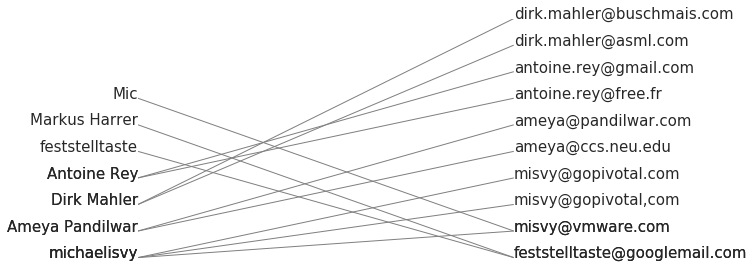

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
# some configuration for displaying nice diagrams directly in the notebook
plt.style.use('fivethirtyeight')
# apply additional style for getting a blank background


fig1 = plt.figure(facecolor='white')
ax1 = plt.axes(frameon=False)
ax1.set_frame_on(False)
ax1.get_xaxis().tick_bottom()
ax1.axes.get_yaxis().set_visible(False)
ax1.axes.get_xaxis().set_visible(False)

for data in plot_data.iterrows():
    row = data[1]
    plt.text(0, row['normalized_index_name'], row['name'], fontsize=15, horizontalalignment="right")
    plt.text(1, row['normalized_index_email'], row['email'], fontsize=15, horizontalalignment="left")
    plt.plot([0,1],[row['normalized_index_name'],row['normalized_index_email']],'grey', linewidth=1.0)

Alright! Here we are! We see that multiple authors use multiple email addresses. And I see a pattern that will do it to get better data. Do you, too? 

## Interlude - end

If you skipped the interlude: just visualized that there are different email adresses per author (and vise versa). Some authors choose to use another email address and some choose a different name for committing to the repositories (and probably a few did both things).

## Data Wrangling

That mess above is a typical case of a little data messiness and &ndash; to demotivate you &ndash; absolutely normal. So we have to do some data correction before we start our analysis. Otherwise we would ignore reality completely and deliver wrong results (as do most of the standard software analysis tools ;-) ).

But first things first. I mean there are some standard steps one should do with the raw data. One is to correct the data types. In our case, we want to convert the "epoch" timestamp, which is the number of ms since 01-01-1970 00:00:00.000.

In [41]:
commits['time'] = pd.to_datetime(commits['time'], unit="ms")
commits.head()

,email,name,time
0,feststelltaste@googlemail.com,Markus Harrer,2017-03-07 07:12:45
1,feststelltaste@googlemail.com,feststelltaste,2016-07-28 19:03:03
2,feststelltaste@googlemail.com,feststelltaste,2017-02-20 15:19:39
3,feststelltaste@googlemail.com,feststelltaste,2017-02-20 16:57:23
4,feststelltaste@googlemail.com,feststelltaste,2017-02-20 16:46:53


Next we want to fix the problem with the multiple authors having multiple email adresses (but are the same persons). We need a mapping between them. Should we do it manually? That would be kind of crazy. As mentioned above, there is a pattern in the data to fix that. We simply use the name of the email address as identifier for a person.

Let's give it a try by extracting the name part from the email address with a simple split.

In [42]:
commits['nickname'] = commits['email'].apply(lambda x : x.split("@")[0])
commits.head()

,email,name,time,nickname
0,feststelltaste@googlemail.com,Markus Harrer,2017-03-07 07:12:45,feststelltaste
1,feststelltaste@googlemail.com,feststelltaste,2016-07-28 19:03:03,feststelltaste
2,feststelltaste@googlemail.com,feststelltaste,2017-02-20 15:19:39,feststelltaste
3,feststelltaste@googlemail.com,feststelltaste,2017-02-20 16:57:23,feststelltaste
4,feststelltaste@googlemail.com,feststelltaste,2017-02-20 16:46:53,feststelltaste


That looks pretty good. Now we want to get only the person's real name instead of the nickname. We use a little heuristic to determine the "best fitting nme" and replace all the others. For this, we need to group the nicknames to replace the names.

In [43]:
def determine_real_name(names):
    
    real_name = ""
    
    for name in names:
        # assumption: if there is a whitespace in the name, 
        # someone thought about it to be first name and surname
        if " " in name:
            return name
        # else take the longest name
        elif len(name) > len(real_name):
            real_name = name
            
    return real_name
        
commits_grouped = commits[['nickname', 'name']].groupby(['nickname']).agg(determine_real_name)
commits_grouped = commits_grouped.rename(columns={'name' : 'real_name'})
commits_grouped.head()

,real_name
nickname,
Andrej1,AndrejGajdos
ameya,Ameya Pandilwar
angel.aguilera,Angel Aguilera
antoine.rey,Antoine Rey
armagan.ersoz,kadinyazilimci


That looks great! Now we switch back to our previous DataFrame by joining in the new information.

In [44]:
commits = commits.merge(commits_grouped, left_on='nickname', right_index=True)
commits.head()

,email,name,time,nickname,real_name
0,feststelltaste@googlemail.com,Markus Harrer,2017-03-07 07:12:45,feststelltaste,Markus Harrer
1,feststelltaste@googlemail.com,feststelltaste,2016-07-28 19:03:03,feststelltaste,Markus Harrer
2,feststelltaste@googlemail.com,feststelltaste,2017-02-20 15:19:39,feststelltaste,Markus Harrer
3,feststelltaste@googlemail.com,feststelltaste,2017-02-20 16:57:23,feststelltaste,Markus Harrer
4,feststelltaste@googlemail.com,feststelltaste,2017-02-20 16:46:53,feststelltaste,Markus Harrer


That should be enough data cleansing for today!

# Analysis

## Top 10 commiters
TODO: There are multiple commits for users with the same timestamp. Check what that is (maybe we need the commit id for better comparison)

In [45]:
authors_commits = pd.DataFrame(commits['real_name'].value_counts()).rename(columns={'real_name' : 'commits'})
authors_commits.head(10)

,commits
michaelisvy,298
Antoine Rey,112
Dirk Mahler,51
Keith Donald,35
Markus Harrer,29
Costin Leau,28
Cyrille Le Clerc,5
Tomas Repel,5
Thibault Duchateau,5
Gordon Dickens,5


### Visualization

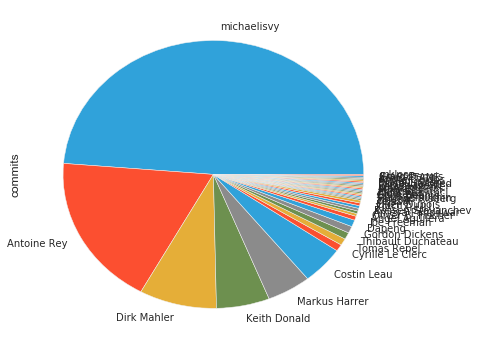

In [46]:
%matplotlib inline 
authors_commits['commits'].plot(kind='pie', figsize=(6,6))

Uhh...that looks ugly and kind of weird. Let's first try to fix the mess on the right side that shows all authors with minor changes by summing up their number of changes. We will use a somehow arbitrary threshold value to identify them.

In [47]:
authors_minor_commits = authors_commits[authors_commits['commits'] < 10]
authors_minor_commits.head()

,commits
Cyrille Le Clerc,5
Tomas Repel,5
Thibault Duchateau,5
Gordon Dickens,5
Dapeng,5


These are the entries we want to combine to our new "Others" section. But we don't want to loose the number of changes, so we store them for lates usage.

In [48]:
others_number_of_changes = authors_minor_commits.sum()
others_number_of_changes

commits    59
dtype: int64

Now we are deleting all authores that are in the <tt>author_minor_changes</tt>'s DataFrame. To not check on the threshold value from above again, we reuse the already calculated DataFrame.

In [49]:
authors_major_commits = authors_commits[~authors_commits.isin(authors_minor_commits)]
authors_major_commits.tail()

,commits
Attilio,NaN
AndrejGajdos,NaN
IHABRITANE,NaN
Craig Dennis,NaN
mklose,NaN


This gives us for the contributors with just a few commits missing values for the <tt>changes</tt> column, because these values were in the <tt>author_minor_changes</tt> DataFrame. We drop all Nan values to get only the major contributors.

In [50]:
authors_major_commits = authors_major_commits.dropna()
authors_major_commits

,commits
michaelisvy,298.0
Antoine Rey,112.0
Dirk Mahler,51.0
Keith Donald,35.0
Markus Harrer,29.0
Costin Leau,28.0


We add the "Others" row by appending to the DataFrame

In [51]:
authors_major_commits.loc["Others"] = others_number_of_changes
authors_major_commits

,commits
michaelisvy,298.0
Antoine Rey,112.0
Dirk Mahler,51.0
Keith Donald,35.0
Markus Harrer,29.0
Costin Leau,28.0
Others,59.0


Almost there, redraw with some styling and minor adjustments.

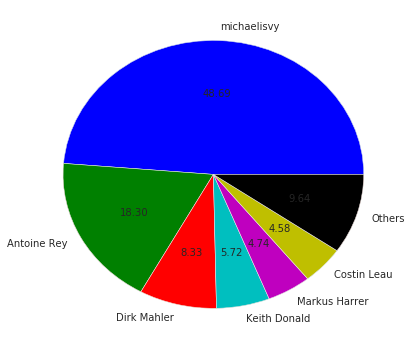

In [52]:
ax = authors_major_commits['commits'].plot(kind='pie', figsize=(6,6))
# show percentages in sections
plt.pie(authors_major_commits['commits'], autopct='%.2f')#
# get rid of the distracting label for the y-axis
ax.set_ylabel("")


# Summary
What we got here is a premium and robust data analysis. I hope you saw that there are some minor difficulties in working with data. We got the big problem of changes of author and email adresses we solved by correcting the names.

But what can we do in practice with these results? Where is the business value? You got me (and I got you): There is almost none! That's the problem we are facing in many data analysis tasks we do in software development today. What value does a simple listing of some characteristics of the contributors of our project or the commit time acutally deliver? It's just nice to know. So in the next notebook, I'll show you where we have to head for.